In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

In [3]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [4]:
data_sample_2 = pd.read_csv('data.csv',',', index_col=['date'], parse_dates=['date'])

In [5]:
data_sample_2

,host,searches
date,,
2016-01-01,iOS,23833
2016-01-01,mobile_web,8708
2016-01-02,Android,1
2016-01-02,iOS,25793
2016-01-02,mobile_web,9012
...,...,...
2018-12-30,web,74387
2018-12-31,Android,18125
2018-12-31,iOS,36215


# iOS Анализ

In [6]:
dataset = pd.DataFrame()
dataset = data_sample_2[data_sample_2["host"] == 'iOS']

In [7]:
dataset=dataset[['searches']]

In [8]:
plotly_df(dataset)

Критерий Дики-Фуллера: p=0.532525


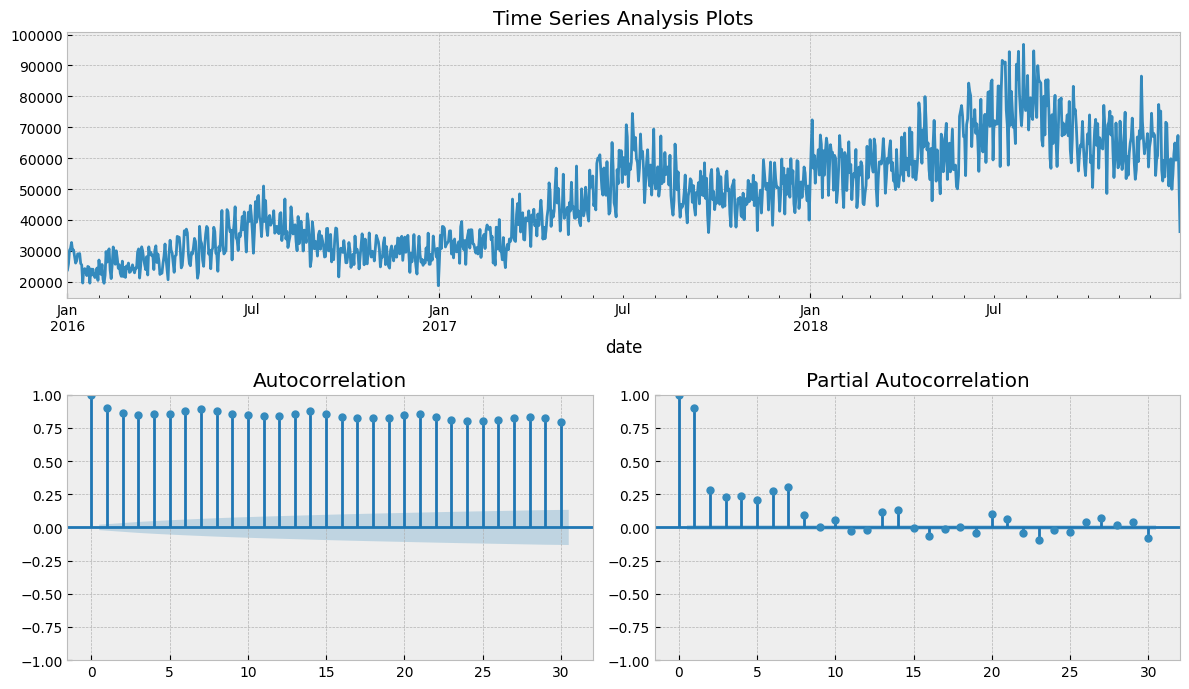

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.searches, lags=30)

In [10]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.searches)
tsplot(data.Users_box, lags=30)

Критерий Дики-Фуллера: p=0.452101


In [11]:
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.201371


In [12]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

Критерий Дики-Фуллера: p=0.405391


In [13]:
data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

Критерий Дики-Фуллера: p=0.000000


In [14]:
d=1
D=1

In [15]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(6, D, 1, 12)).fit(disp=-1)
print(best_model.summary())    

/Users/viktoriagolovneva/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/viktoriagolovneva/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/viktoriagolovneva/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                            Users_box   No. Observations:                 1096
Model:             SARIMAX(4, 1, 3)x(6, 1, [1], 12)   Log Likelihood               -1588.871
Date:                              Sat, 17 Dec 2022   AIC                           3207.742
Time:                                      21:44:59   BIC                           3282.555
Sample:                                  01-01-2016   HQIC                          3236.066
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1157      0.066     16.986      0.000       0.987       1.244
ar.L2         -1.02

In [16]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+400), lmbda)
forecast = data.arima_model.append(forecast).values[-1500:]
actual = data.searches.values[-1200:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().searches, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

# mobile_web Анализ

In [17]:
dataset = pd.DataFrame()
dataset = data_sample_2[data_sample_2["host"] == 'mobile_web']

dataset=dataset[['searches']]

plotly_df(dataset)

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.searches, lags=30)

Критерий Дики-Фуллера: p=0.542446


In [19]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.searches)
tsplot(data.Users_box, lags=30)

Критерий Дики-Фуллера: p=0.534025


In [20]:
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.485443


In [21]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

Критерий Дики-Фуллера: p=0.599876
Критерий Дики-Фуллера: p=0.000000


In [22]:
d=1
D=1

In [23]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(6, D, 1, 12)).fit(disp=-1)
print(best_model.summary())    

/Users/viktoriagolovneva/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/viktoriagolovneva/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/viktoriagolovneva/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                            Users_box   No. Observations:                 1096
Model:             SARIMAX(4, 1, 3)x(6, 1, [1], 12)   Log Likelihood               -4536.613
Date:                              Sat, 17 Dec 2022   AIC                           9103.226
Time:                                      21:48:44   BIC                           9178.038
Sample:                                  01-01-2016   HQIC                          9131.550
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0564      0.269     -0.210      0.834      -0.584       0.471
ar.L2          0.34

In [24]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+400), lmbda)
forecast = data.arima_model.append(forecast).values[-1500:]
actual = data.searches.values[-1200:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().searches, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)